In [9]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd 
pd.set_option('display.float_format', '{:0.8f}'.format)
import warnings
import operator
import os, sys
# don't need this because I am not solving MM or through the equation, but I can import my own functions 
# from daeFinder import solveMM, plotToy_MM, plotToyEnz

from srh_traps import solve_srh_traps, plot_srh_solution
from non_dim_solver import solve_nd_srh_traps

from daeFinder import add_noise_to_df
from daeFinder import smooth_data
from matplotlib import pyplot as plt
from daeFinder import PolyFeatureMatrix
from sklearn.preprocessing import StandardScaler
import sympy
from daeFinder import sequentialThLin, AlgModelFinder
from daeFinder import get_simplified_equation_list
from daeFinder import construct_reduced_fit_list
from sklearn.linear_model import LinearRegression
from daeFinder import get_refined_lib, remove_paranth_from_feat
from daeFinder import sequentialThLin, AlgModelFinder



Importing the Toy Model for SRH Recombination 

In [10]:
# import numpy as np
# import pandas as pd
# from scipy.integrate import solve_ivp

# # --- Constants and reference scales ---
# k_B = 8.617e-5  # eV/K
# q = 1
# N_C = 2.8e19
# N_V = 1.04e19
# E_C = 1.12
# E_V = 0.0
# E_t = 0.56
# n_i = 1.5e10

# c_n = 1e-8
# c_p = 1e-8
# N_t = 1e12

# # Scales for non-dimensionalization
# n_scale = 1e12
# p_scale = 1e12
# nt_scale = N_t
# t_scale = 1 / (c_n * N_t)

# # Emission rates
# def get_emission_rates(T):
#     n1 = N_C * np.exp(-(E_C - E_t) / (k_B * T))
#     p1 = N_V * np.exp(-(E_t - E_V) / (k_B * T))
#     return c_n * n1, c_p * p1

# # --- Dimensionless ODE system ---
# def solve_srh_traps_dimensionless(IC, params, t_span):
#     # Non-dimensional initial conditions
#     n0 = IC["n"] / n_scale
#     p0 = IC["p"] / p_scale
#     nt0 = IC["n_t"] / nt_scale
#     y0 = [n0, p0, nt0]

#     e_n, e_p = get_emission_rates(params["T"])
#     eps_n = e_n * t_scale / n_scale
#     eps_p = e_p * t_scale / p_scale

#     def srh_system_nd(t, y):
#         n, p, nt = y
#         pt = 1.0 - nt
#         denom = n + p + eps_n + eps_p
#         ft = (n + eps_p) / denom if denom > 0 else 0.0

#         dn_dt = -n * pt + eps_n * nt
#         dp_dt = -p * nt + eps_p * pt
#         dnt_dt = n * pt - eps_n * nt - p * nt + eps_p * pt
#         return [dn_dt, dp_dt, dnt_dt]

#     # Dimensionless time span
#     t0, tf = t_span[0] / t_scale, t_span[1] / t_scale
#     t_eval = np.linspace(t0, tf, 50)

#     # Solve and rescale results
#     sol = solve_ivp(srh_system_nd, (t0, tf), y0, t_eval=t_eval, method='RK45')

#     # Rescale for output
#     n = sol.y[0] 
#     p = sol.y[1]
#     nt = sol.y[2] 
#     pt = N_t - nt
#     t = sol.t 

#     return t, n, p, nt, pt

# # --- Setup ---
# final_time = 1
# time_grid = np.linspace(0, final_time, 50)

# params_list = [{"V": 0.7, "T": 300}]
# IC_list = [
#     {"n": 1e12, "p": 1e5, "n_t": 1e10, "p_t": 1e10},
#     # {"n": 1e10, "p": 1e10, "n_t": 1e8, "p_t": 1e8},
#     # {"n": 1e9, "p": 1e9, "n_t": 1e7, "p_t": 1e7},
#     # {"n": 1e15, "p": 1e15, "n_t": 1e12, "p_t": 1e12},
#     # {"n": 1e14, "p": 1e14, "n_t": 1e6, "p_t": 1e6},
#     # {"n": 1e13, "p": 1e9, "n_t": 1e10, "p_t": 1e10}
# ]

# def get_block_symbol(feature_list):
#     return ["[{}]".format(feat) for feat in feature_list]

# # --- Loop and build dataframe ---
# data_matrix_df_list = []

# for params in params_list:
#     for IC in IC_list:
#         t, n, p, nt, pt = solve_srh_traps_dimensionless(IC, params, t_span=(time_grid[0], time_grid[-1]))
#         sol_df = pd.DataFrame({
#             "t": t,
#             "n": n,
#             "p": p,
#             "n_t": nt,
#             "p_t": pt
#         })
#         sol_df = sol_df.rename(columns=dict(zip(sol_df.columns, get_block_symbol(sol_df.columns))))
#         data_matrix_df_list.append(sol_df)

# data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)

# data_matrix_df

In [11]:
import numpy as np
import pandas as pd
from non_dim_solver import solve_nd_srh_traps

# --- Utility for bracketed column names ---
def get_block_symbol(feature_list):
    return ["[{}]".format(feat) for feat in feature_list]

# --- Time grid and setup ---
final_time = 1
num_time_points = 50
time_grid = np.linspace(0, final_time, num_time_points)
t_span = (0, final_time)

# --- Parameter sets and initial conditions ---
params_list = [{"V": 0.7, "T": 300}]
IC_list = [
    {"n": 1e12, "p": 1e5, "n_t": 1e10},
    {"n": 1e10, "p": 1e10, "n_t": 1e8},
    {"n": 1e9,  "p": 1e9,  "n_t": 1e7},
    {"n": 1e15, "p": 1e15, "n_t": 1e12},
    {"n": 1e14, "p": 1e14, "n_t": 1e6},
    {"n": 1e13, "p": 1e9,  "n_t": 1e10},
]

# --- Main loop ---
data_matrix_df_list = []

for params in params_list:
    for IC in IC_list:
        t_out, n, p, n_t, p_t = solve_nd_srh_traps(IC=IC, param_overrides=params, t_eval=time_grid)

        sol_df = pd.DataFrame({
            "n": n,
            "p": p,
            "n_t": n_t,
            "p_t": p_t,
            "t": t_out
        })

        # Rename columns to bracket notation
        sol_df.columns = get_block_symbol(sol_df.columns)

        # Optional: add IC and param metadata to each row
        # for k, v in IC.items():
        #     sol_df[f"[IC_{k}]"] = v
        # for k, v in params.items():
        #     sol_df[f"[param_{k}]"] = v

        data_matrix_df_list.append(sol_df)

# --- Final concatenated DataFrame ---
data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)


Adding Noise 

In [12]:
noise_perc = 0


data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["[t]"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["[t]"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

In [13]:
data_matrix_smooth_df_list = [smooth_data(data_matrix,domain_var="[t]",derr_order=1, noise_perc=noise_perc,
                                          eval_points=t_exact) for data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) >1:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
if "[t]" in data_matrix_df_smooth:
    data_matrix_df_smooth = data_matrix_df_smooth.drop("[t]", axis=1)

data_matrix_smooth_df_list

[          [t]                    [n]               d([n]) /dt             [p]  \
 0  0.00000000 1000000000000.00024414 -93040104385704.81250000 100000.00000000   
 1  0.02040816   11476016184.30012131 -14043042272615.77929688  -2335.04004720   
 2  0.04081633   10169856449.07082367   3707242374181.32128906   5935.42799673   
 3  0.06122449   10021659981.56849861   -999717585911.05273438 -11247.17510939   
 4  0.08163265   10002721660.63880920    267059155563.38439941  15268.27295533   
 5  0.10204082   10000266551.90682030    -71663870502.75051880  -1575.15936000   
 6  0.12244898    9999947725.82230568     19188558029.59196472 -10306.29371424   
 7  0.14285714    9999906111.66514015     -5143346331.14438057   7576.19676128   
 8  0.16326531    9999900807.00135612      1377930228.30591726   -202.64900895   
 9  0.18367347    9999900152.53081703      -369250574.82511246  -4652.53949832   
 10 0.20408163    9999899901.72851562        98938995.88693246  11180.67303203   
 11 0.22448980  

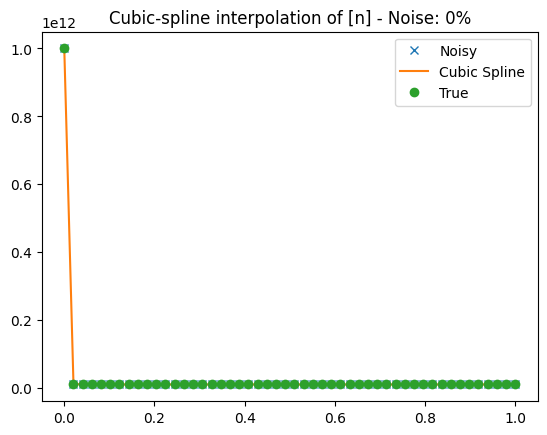

In [14]:
from matplotlib import pyplot as plt
ind = 0
feature_ = "[n]"

plt.figure()
# plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
#         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

plt.plot(data_matrix_df_list[ind]["[t]"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["[t]"],
         data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["[t]"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
plt.legend(['Noisy', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
plt.show()

<Axes: >

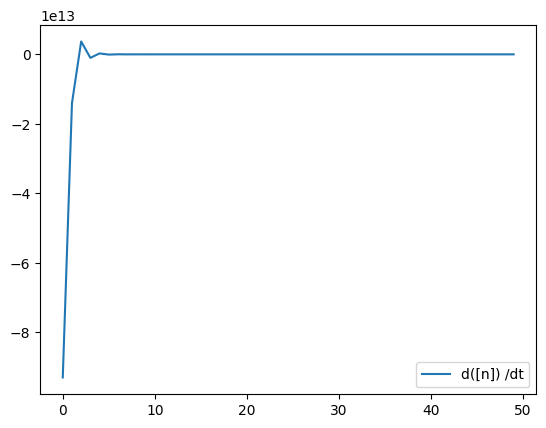

In [15]:
data_matrix_smooth_df_list[0][["d([n]) /dt"]].plot()


In [16]:
poly_degree = 2

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)


#Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
# in the candidate library
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

,[n],[p],[n_t],[p_t],[n]^2,[n] [p],[n] [n_t],[n] [p_t],[p]^2,[p] [n_t],[p] [p_t],[n_t]^2,[n_t] [p_t],[p_t]^2
0,1000000000000.00024414,100000.00000000,10000000000.00000572,990000000000.00012207,1000000000000000520093696.00000000,100000000000000032.00000000,10000000000000008388608.00000000,990000000000000423624704.00000000,10000000000.00000000,1000000000000000.62500000,99000000000000016.00000000,100000000000000114688.00000000,9900000000000007340032.00000000,980100000000000275775488.00000000
1,11476016184.30012131,-2335.04004720,998523881480.65942383,1476118519.34070325,131698947462318309376.00000000,-26796957372669.61718750,11459076224282223706112.00000000,16939960017899042816.00000000,5452412.02203327,-2331593251344100.50000000,-3446795857075.84570312,997049941887202050965504.00000000,1473939593457562812416.00000000,2178925883140590080.00000000
2,10169856449.07082367,5935.42799673,999830049486.35717773,169950513.64294505,103425980194707423232.00000000,60362450690572.75781250,10168128076743631175680.00000000,1728372327194603776.00000000,35229305.50440441,5934419267696476.00000000,1008729036735.52551270,999660127855891441516544.00000000,169921630465857585152.00000000,28883177087500852.00000000
3,10021659981.56849861,-11247.17510939,999978228771.25610352,21771228.74389859,100433668786171527168.00000000,-112715364699473.68750000,10021441797716646559744.00000000,218183851852302272.00000000,126498947.94129682,-11246930244568632.00000000,-244864822029.22665405,999956458016498597756928.00000000,21770754757497565184.00000000,473986401019156.00000000
4,10002721660.63880920,15268.27295533,999997193607.63342285,2806392.36645491,100054440620212813824.00000000,152724284610852.40625000,10002693589077095088128.00000000,28071561712189976.00000000,233120159.03854480,15268230106568056.00000000,42848764670.79578400,999994387223142664765440.00000000,2806384490616799232.00000000,7875838114496.41308594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,9009000895711.77734375,-0.00000000,999999104287.93432617,895712.06555176,81162097138935606781411328.00000000,-4095.84713531,9008992826240974878408704.00000000,8069470800855631872.00000000,0.00000000,-454.63903423,-0.00040723,999998208576670973034496.00000000,895711263251653376.00000000,802300104374.99645996
296,9009001319467.30859375,-0.00000000,999998680532.36181641,1319467.63854981,81162104774163702627696640.00000000,-6033.55598205,9008989432381614919254016.00000000,11887085696689608704.00000000,0.00000000,-669.72440196,-0.00088368,999997361066464639975424.00000000,1319465897554956544.00000000,1740994849180.19921875
297,9008999652608.45898438,0.00000000,1000000347391.16418457,-347391.16406250,81162074740699334443008000.00000000,1588.64660571,9009002782255336313061376.00000000,-3129646876358308864.00000000,0.00000000,176.34001763,-0.00006126,1000000694782449036558336.00000000,-347391284743120768.00000000,120680620868.69866943
298,9009000585081.43359375,-0.00000000,999999414918.14221191,585081.85791016,81162091541997611208671232.00000000,-2675.39366175,9008995314078634087546880.00000000,5271002800233131008.00000000,0.00000000,-296.96880039,-0.00017375,999998829836626728845312.00000000,585081515589376000.00000000,342320780455.60040283


In [17]:
s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib_full), columns=s_scaler.feature_names_in_)
if '1' in scaled_cand_lib.columns:
        scaled_cand_lib['1'] = 1

scaled_cand_lib.describe()


,[n],[p],[n_t],[p_t],[n]^2,[n] [p],[n] [n_t],[n] [p_t],[p]^2,[p] [n_t],[p] [p_t],[n_t]^2,[n_t] [p_t],[p_t]^2
count,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000
mean,0.08939104,0.06332350,0.98775090,1.01374943,0.05864547,0.05840884,0.08338096,0.06384395,0.05840884,0.05783150,0.05786758,0.98675685,0.34492137,1.01341779
std,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084
min,-0.00000000,-0.00000000,0.00000200,-0.00000225,0.00000000,-0.00000000,-0.00000000,-0.00000175,0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00116761,0.00000000
25%,0.00000000,0.00000000,0.00040900,0.00000071,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000,0.00000008,0.00036921,0.00000000
50%,0.00000182,0.00000104,0.01517405,1.98632628,0.00000000,0.00000000,0.00000174,0.00000000,0.00000000,0.00000000,0.00001010,0.00012671,0.15001856,1.97192851
75%,0.00017268,0.00000303,2.00149962,2.00109133,0.00000000,0.00000000,0.00017346,0.00000000,0.00000000,0.00000000,0.00002992,2.00083262,0.27293267,2.00134165
max,17.26844506,17.26906924,2.00150259,2.00149833,17.34939731,17.34916074,17.34615498,17.27050161,17.34916074,17.34944797,17.34948391,2.00083855,10.27045798,2.00215583


In [18]:
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")
feat_list


['[n]', '[p]', '[n_t]', '[p_t]', '[t]']

In [19]:
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=True)

algebraic_model_lasso.fit(data_matrix_df_smooth, scale_columns= True)

AlgModelFinder(fit_intercept=True)

In [20]:
#Best 10 models using R2 metrix
algebraic_model_lasso.best_models(5)

,[n_t],[p_t],[n],[p]
[n],0.00000000,-0.00000000,NaN,0.89828056
[p],0.00000000,-0.00000000,0.89834550,NaN
[p_t],-0.90000000,NaN,-0.00000000,0.00000000
[n_t],NaN,-0.90000000,0.00000000,-0.00000000
r2- metric,0.99000000,0.99000000,0.98662891,0.98662891


In [21]:

algebraic_model_lasso.get_fitted_intercepts()

{'[n]': np.float64(1885579421690.9404),
 '[p]': np.float64(-984766395250.646),
 '[n_t]': np.float64(950936741366.8328),
 '[p_t]': np.float64(952237864021.5739)}

In [22]:
##THIS WAS NOT WORKING WHEN I PUT p IN 
# features_to_remove = {E}

# features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
#                                                   candidate_lib_full, get_dropped_feat=True)

<Axes: >

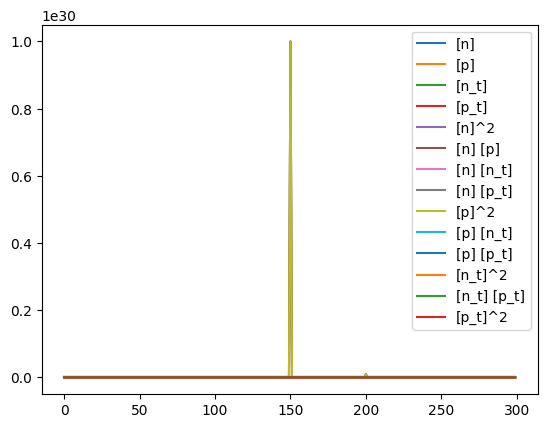

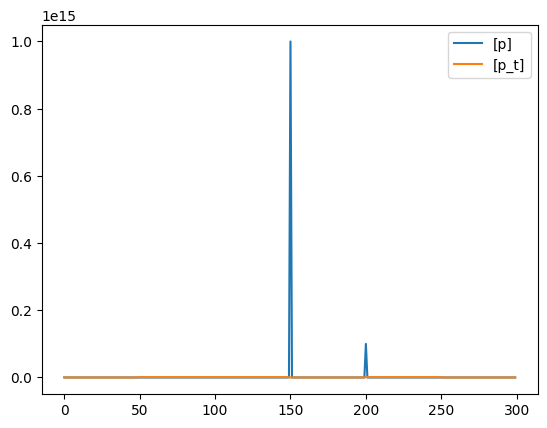

In [23]:

algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=False, alpha=0.01)
algebraic_model_lasso.fit(candidate_lib_full, scale_columns= True)
# algebraic_model_lasso.fit(scaled_cand_lib, scale_columns= False)

candidate_lib_full.plot()
data_matrix_df[['[p]','[p_t]']].plot()

In [24]:
# algebraic_model_lasso.best_models()
best_models_full = algebraic_model_lasso.best_models()

best_models_full

,[p_t]^2,[p_t],[n_t]^2,[n_t],[n]^2,[p]^2,[n] [p],[p] [n_t],[p],[n] [n_t],[n],[p] [p_t],[n] [p_t],[n_t] [p_t]
[n],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.25015978,708597792787.42504883,NaN,0.00000000,0.00000000,-0.00000000
[p],0.00000000,0.00000000,0.00000000,0.00000000,31852122830287.96484375,32003701580924.91406250,32191382755874.55078125,31856655548.81715393,NaN,0.00000000,0.29996795,0.00000000,0.00000000,-0.00000000
[n_t],-0.00000000,0.00000000,994771630266.90161133,NaN,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,351406164044.42767334,0.40221652,0.00000000,-0.00000000,155032194.97408372
[p_t],994573862328.87841797,NaN,-0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,30358811806.15955353,-0.00000000,438539431.13469332
[n]^2,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.86149150,0.86132131,0.00093717,0.00000000,0.00018799,0.00000000,0.00000000,0.00000000,-0.00000000
[n] [p],0.00000000,0.00000000,0.00000000,0.00000000,0.86675118,0.00512321,NaN,0.00000530,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000
[n] [n_t],-0.00000000,0.00000000,0.00000000,0.00000000,23.54431985,9.41322689,9.53110478,0.01560930,0.00000000,NaN,0.00000000,-0.00000000,0.00000000,-0.00000006
[n] [p_t],0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000,-0.62804576,0.00000000,0.98308782,NaN,0.00070282
[p]^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00375028,NaN,0.00576604,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000
[p] [n_t],0.00000000,0.00000000,0.00000000,0.00000000,64.13540409,82.00152158,81.22333410,NaN,0.00000000,0.09309410,0.00000000,0.00000000,0.00000000,-0.00000000


In [25]:
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()
intercept_dictionary

# simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
#                             coef_threshold=0.05,
#                             intercept_threshold= 0.01,
#                              global_feature_list=data_matrix_df.columns,
#                              intercept_dict= intercept_dictionary,
#                              simplified = True)

{'[n]': np.float64(0.0),
 '[p]': np.float64(0.0),
 '[n_t]': np.float64(0.0),
 '[p_t]': np.float64(0.0),
 '[n]^2': np.float64(0.0),
 '[n] [p]': np.float64(0.0),
 '[n] [n_t]': np.float64(0.0),
 '[n] [p_t]': np.float64(0.0),
 '[p]^2': np.float64(0.0),
 '[p] [n_t]': np.float64(0.0),
 '[p] [p_t]': np.float64(0.0),
 '[n_t]^2': np.float64(0.0),
 '[n_t] [p_t]': np.float64(0.0),
 '[p_t]^2': np.float64(0.0)}